In [5]:
import numpy as np, math
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

In [6]:
import torch
print(torch.__version__)
print(torch.version.cuda)         # Should not be None
print(torch.backends.cudnn.version())  # Should return a number if CUDA is working

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.6.0+cu124
12.4
90100
cuda


In [7]:
def show_imgs(imgs, title=None):
    # Plot the grid
    fig, axs = plt.subplots(figsize=(12, 5), ncols=4, nrows=2)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i], interpolation="nearest", cmap='Greys_r')
        ax.axis("off")
    plt.show()
    plt.close()

# get dataset

In [8]:
# Convert images from 0-1 to 0-255 (integers)
def norm_data(sample):
    return (sample - sample.mean())/sample.std() 
    #return (sample * 255).to(torch.float32)
    #return sample

trs = transforms.Compose([transforms.ToTensor(), transforms.Normalize])

# loading training set
mnist_dataset = MNIST(root='./', train=True, transform=trs, download=True)

# loading test set
test_set = MNIST(root='./', train=False, transform=trs, download=True)

100%|██████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 3.25MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 308kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.11MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]


# init network

In [10]:
from networks_torch import UNet

start_epoch = 1
nr_epochs = 100
batch_size = 32

# define a set of data loaders
data = mnist_dataset.data.numpy()
target_dataset = torch.tensor(data, dtype=torch.float32)
input_dataset = torch.tensor(data + np.random.normal(loc=0, scale=50, size=data.shape), dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(input_dataset[:,None,...], target_dataset[:,None,...])
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

params = {'depth': 1, 'activation': 'ReLU', 'coarse_dim': 16, 'kernel_size': 3, 'dropout': 0.05, 'final_activation': False}
unet = UNet(img_shape=(1, 28, 28), params=params)

# Move model to device
unet = unet.to(device)

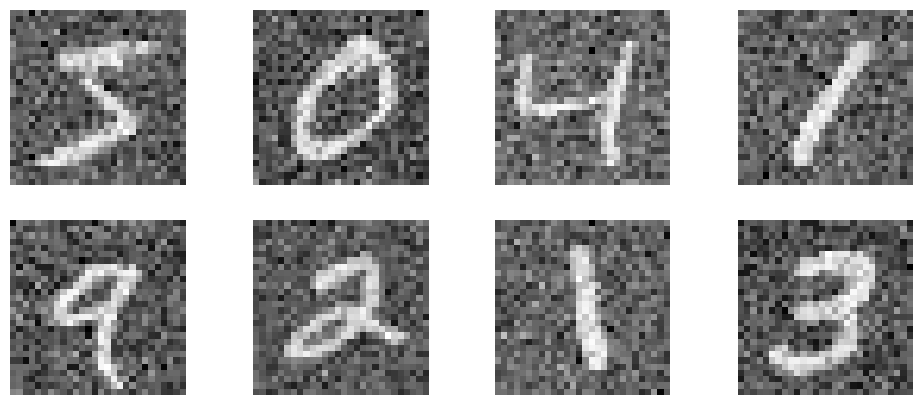

tensor(517.7413)


In [11]:
show_imgs(imgs=input_dataset[:8].cpu().detach().numpy().squeeze())
print(input_dataset.max())

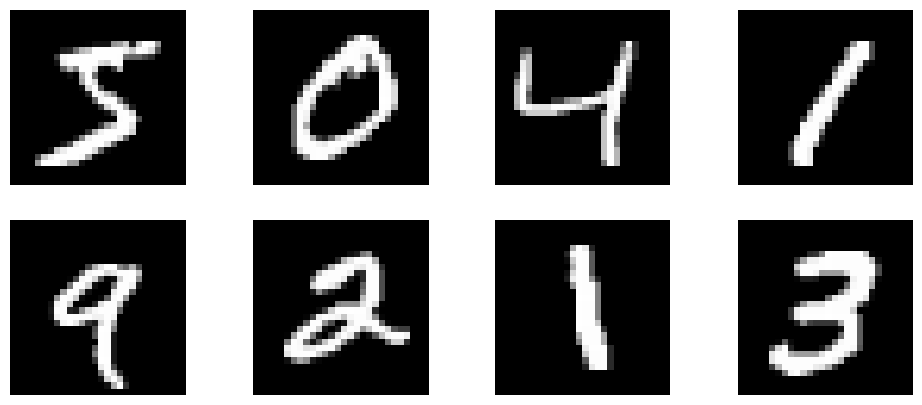

tensor(255.)


In [12]:
show_imgs(imgs=target_dataset[:8].cpu().detach().numpy().squeeze())
print(target_dataset.max())

In [9]:
loss_array = []

optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=20, min_lr=1e-17, verbose=True)
mse_loss = nn.MSELoss()

for epoch in tqdm(range(start_epoch, nr_epochs + 1), desc="Epoch:"):
    unet.train()

    loss_batch = []
    nr_batch = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Setting the gradient attribute of each weight to zero
        optimizer.zero_grad()

        # Computing the forward pass
        y = unet(x_batch)
        
        # Computing the loss
        loss = mse_loss(y, y_batch)
        loss_batch.append(loss.item())
        
        # Computing the gradient w.r.t. model parameters
        loss.backward()

        # Adjusting the weights using SGD
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        optimizer.step()
        
        #print(' Epoch: %02d-%03d\tloss = %.3f' %(epoch,nr_batch, loss.item()))
        nr_batch += 1
        
        # Define Weighted BCE Loss
        #criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        #loss = criterion(y_pred, y_true)
        
    # Update LR at the end of the epoch
    scheduler.step()
    
    # Collect loss
    loss_array.append(np.mean(loss_batch))
    
loss_array = np.array(loss_array)

Epoch:: 100%|███████████████████████████████████| 10/10 [00:49<00:00,  4.97s/it]


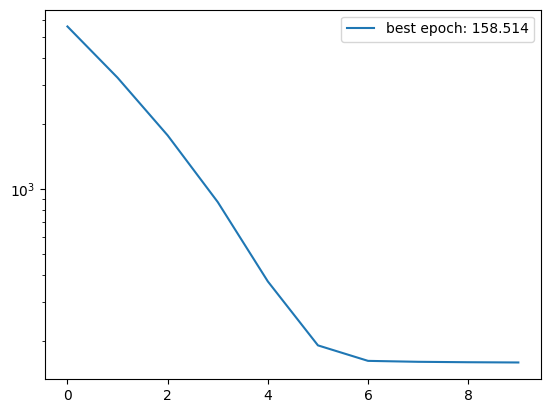

(None, None)

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot loss
plt.semilogy(loss_array, label='best epoch: %.3f' %loss_array.min())
plt.legend()
plt.show(), plt.clf()

In [11]:
#unet.eval()
with torch.no_grad():
    for x_val, y_val in valid_loader:
        y = unet(x_val.to(device))
        break

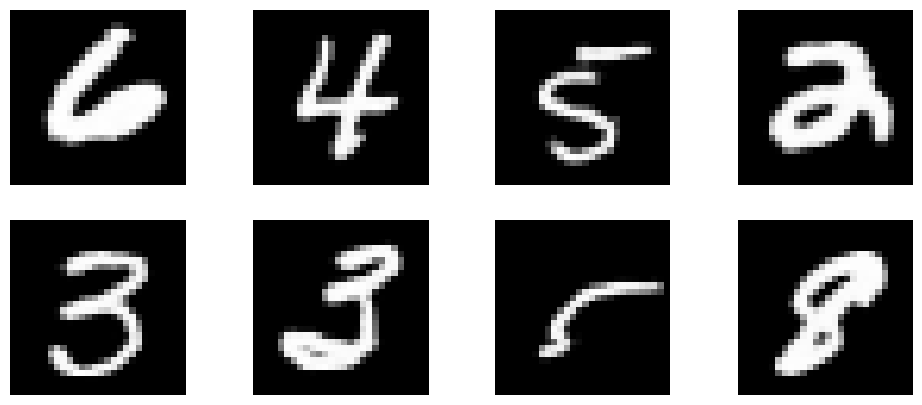

In [12]:
show_imgs(imgs=y.cpu().detach().numpy().squeeze())

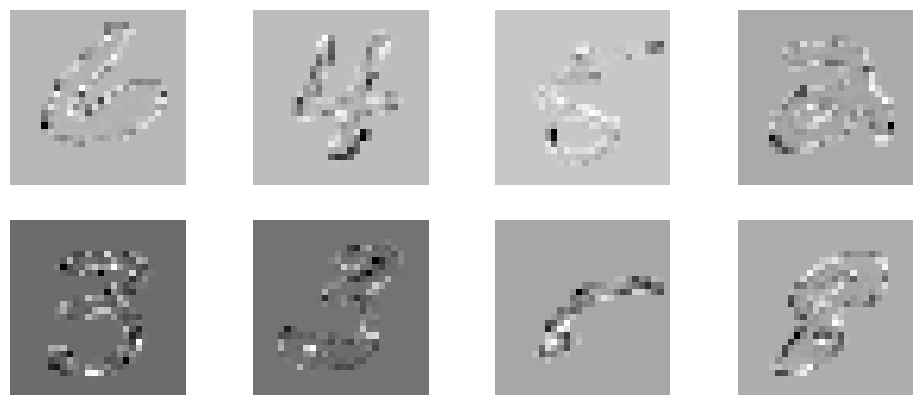

148.40187 -0.7522731 -179.0


In [14]:
res = y.cpu().detach().numpy().squeeze()-y_val.cpu().detach().numpy().squeeze()
show_imgs(imgs=res)
print(res.max(), res.mean(), res.min())